# Open Boundary Condition

This notebook is used to create the open boundary condition for MOM5. It contains two examples:
1. Estimate eta_t based on linear regression
2. Use preexisting OBC and interpolate onto different grid.

First the constructor class and the obc classes itself are defined. An example is given at the end.

In [7]:
import os
import xarray as xr
import numpy as np
from glob import glob

import subprocess as sp

In [1]:
class obc_parameters:
    """Defines constructor for the OBC in MOM5
    """
    
    def __init__(self):
        
        self.path_forcing = {"pressure":None,
                             "windx": None,
                             "windy": None,
                             "temperature": None}
        self.variables = {"pressure": "",
                          "windx": "",
                          "windy": "",
                          "temperature": ""}
        self.path_to_output = ""

In [3]:
#export
class obc:
    """Class for calculating the open boundary condition in MOM5
    """
    def __init__(self, parameters):
        """Reads in constructor class for the open boundary condition

        Args:
            parameters (class): Contains path to all forcing and dataset
        """
        self.parameters = parameters
        self.etafit = None
        self.data = {}
        self._check_forcing()
        self._check_variables()

    def _check_forcing(self):
        """Check if forcing defines in `parameters` exists
        """
        for file in self.parameters.path_forcing.keys():
            assert os.path.isfile(self.parameters.path_forcing[file]) == True, f"{self.parameters.path_forcing[file]} does not exist"
        
    def _check_variables(self):
        """Reads if variable names exists in forcing files
        """
        for var in self.parameters.variables.keys():
            tmp = xr.open_dataset(self.parameters.path_forcing[var])

            assert self.parameters.variables[var] in list(tmp.data_vars), f"{self.parameters.variables[var]} is missing in {self.parameters.path_forcing[var]}"
    
    def _check_timesteps(self):
        """Calculates maximum timestep in hours"""
        maxh = 0.0
        for var in self.parameters.variables.keys():
            dtimestep = (self.data[var].isel(time = 1).time - self.data[var].isel(time = 0).time).data / np.timedelta64(1, 'h')
            if maxh < dtimestep:
                maxh = dtimestep
        print(f"Your timestep will be {maxh} hours")
        if maxh == 24.0:
            resampleto = "1D"
            
        if (maxh < 24.0) & (maxh > 1):
            resampleto = f"{int(maxh)}H"
        
        for var in self.parameters.variables.keys():
            dtimestep = (self.data[var].isel(time = 1).time - self.data[var].isel(time = 0).time).data / np.timedelta64(1, 'h')
            if maxh > dtimestep:
                print(f"Upsampling of {var} to {resampleto}")
                self.data[var] = self.data[var].resample(time=resampleto).mean("time")

    
    def load_data(self, lonname="lon", latname="lat", timename="time"):
        """Reads data from forcing and cuts out relevant regions for the linear regression

        Args:
            lonname (str, optional): Name of longitude coordinate. Defaults to "lon".
            latname (str, optional): Name of latitude coordinate. Defaults to "lat".
            timename (str, optional): Name of time coordinate. Defaults to "time".
        """                     
        
        self.regions =  {
            "windx": dict(lon=slice(2, 7), lat=slice(54, 56)),
            "windy": dict(lon=slice(14, 27), lat=slice(56, 60)),
            "temperature": dict(lon=slice(4.5, 7), lat=slice(54.5, 57.5)),
            "pressure": dict(lon=slice(7.5, 17.5), lat=slice(62, 68))

        }                        
                                  
        for var in self.parameters.variables.keys():
            self.data[var] = xr.open_dataset(self.parameters.path_forcing[var], use_cftime=True)
            self.data[var] = self.data[var].rename({lonname:"lon", latname:"lat", timename:"time"})[self.parameters.variables[var]]
            self.data[var] = self.data[var].sel(**self.regions[var]).squeeze().load().mean(["lon", "lat"])
            
         
        self._check_timesteps()
        
    def estimate_eta(self):
        """Performs regression to estimate sea level. Needs to be called after load_data()
        """
        a = np.array([94.908, 0.775, 0.067, 0.934, 0.98]) / 100
        p = np.array([ -0.00003047, 0.007329, 1.1939, -1.2723])
        etafit0=a[0]+a[1]*self.data["windx"].data \
                    +a[2]*self.data["windy"].data \
                    +a[3]*(1013-self.data["pressure"].data) \
                    +a[4]*self.data["temperature"].data
        
        self.etafit = np.polyval(p, etafit0)
        
        
    def interpolate_onto_given_obc(self, obcpath, lonname="lon", latname="lat"):
        """        Uses a pre-existing OBC file and interpolates the previously fitted data onto the latitude points
        Note: this procedure makes only sense if OBC option MEANIN is selected.

        Args:
            obcpath (str): Path to existing OBC
            lonname (str, optional): Name of longitude coordinate. Defaults to "lon".
            latname (str, optional): Name of latitude coordinate. Defaults to "lat".

        Returns:
            xr.Dataset: Estimated eta interpolated onto predefined grid
        """                
        if self.etafit is not None:
            dset_ob = xr.open_dataset(obcpath)
            londata = dset_ob[lonname]
            latdata = dset_ob[latname]

            eta_reshape = np.zeros((len(self.etafit),len(latdata),len(londata)))
                            
            for i in range(0, len(latdata)):
                eta_reshape[:,i,0] = self.etafit[:]

            self.dsout = xr.Dataset({
                        "eta_t": (["time", "lat", "lon"], eta_reshape)
                        },
                        coords={
                            "time": (["time"], self.data["pressure"].time.data),
                            "lat":  (["lat"], latdata.data),
                            "lon":  (["lon"], londata.data)
                        })
            return self.dsout
        else:
            print("Use estimate_eta() first.")
            
    def save_interpolated_obc(self, ofolder, filename):
        """Save Dataset to netCDF-file

        Args:
            ofolder (str): Path to outputfolder
            filename (str): Name of obc dataset.
        """
        
        if not os.path.exists(f"{ofolder}"):
            os.makedirs(f"{ofolder}")           
        self.dsout.to_netcdf(f"{ofolder}/{filename}.nc")     

The regression coefficients are based on an analysis of Thomas.

In [ ]:
class copy_obc:
    """
    Copy eta_t from preexisting OBC onto new OBC with different grid.
    An example would be to first run an 8nm run with MOM and then continue with an 3nm simulation.
    Warning:
    Calls nco and cdo, so make sure to have these module loaded
    """
    
    def __init__(self, data, obcpath, ofolder, ofile="obc_trop_west.dta.nc"):
        """Loads necessary data

        Args:
            data (xr.Dataset): xr.Dataset containing sea level
            obcpath (str): Path to new OBC grid
            ofolder (str): Path to output folder
            ofile (str, optional): Name of output file. Defaults to "obc_trop_west.dta.nc".
        """
        self.origdata = xr.open_dataset(data, use_cftime=True)
        self.obcdata = xr.open_dataset(obcpath)
        self.ofolder = ofolder
        self.ofile = ofile
        
    def copy_data(self,
                  datavar="eta",
                  datatime="time",
                  datalat="lat",
                  obclon="lon",
                  obclat="lat"):
        """Copies data from new OBC grid and reads in data from original obc file

        Args:
            datavar (str, optional): name of sea level. Defaults to "eta".
            datatime (str, optional): name of time var. Defaults to "time".
            datalat (str, optional): name of latitude coordinate. Defaults to "lat".
            obclon (str, optional): name of longitude coordinate (new grid). Defaults to "lon".
            obclat (str, optional): name of latitude coordinate (new grid). Defaults to "lat".
        """
        londata = self.obcdata[obclon].data
        latdata = self.obcdata[obclat].data
        
            
        if not os.path.exists(f"{self.ofolder}"):
            os.makedirs(self.ofolder)

        etaNew = np.zeros((len(self.origdata[datatime]),
                           len(latdata),
                           len(londata)))

        for latpoint in range(0, len(latdata)):
            etaNew[:, latpoint, 0] = self.obcdata[datavar].squeeze().mean(datalat).data
        
        dsout = xr.Dataset({
                            "eta_t": (["time", "lat", "lon"], etaNew)
                            },
                            coords={
                                "time": (["time"], self.obcdata[datatime].data),
                                "lat":  (["lat"], latdata),
                                "lon":  (["lon"], londata)
                            })
        dsout.eta_t.attrs = {"long_name": "sea level elevation"}
        dsout.eta_t.attrs = self.obcdata[datavar].attrs
        dsout = dsout.transpose("time", "lat", "lon")
        dsout.to_netcdf(f"{self.ofolder}/tmp.nc")
        sp.check_call(f"cdo setreftime,1850-01-01,00:00:00,hours {self.ofolder}/tmp.nc {self.ofolder}/{self.ofile}", shell=True)
        sp.check_call(f"ncatted -a calendar,time,o,c,julian {self.ofolder}/{self.ofile}", shell=True)
        sp.check_call(f"rm {self.ofolder}/tmp.nc", shell=True)

## Example

In [8]:
parameters = obc_parameters()

parameters.path_forcing["pressure"] = "/data/meteo/BalticSea/reconstructions/hiresaff_v02/1850/pair.mom.dta.nc"
parameters.path_forcing["windx"] = "/data/meteo/BalticSea/reconstructions/hiresaff_v02/1850/windx.mom.dta.nc"
parameters.path_forcing["windy"] = "/data/meteo/BalticSea/reconstructions/hiresaff_v02/1850/windy.mom.dta.nc"
parameters.path_forcing["temperature"] = "/data/meteo/BalticSea/reconstructions/hiresaff_v02/1850/tair.mom.dta.nc"

parameters.variables["pressure"] = "pair"
parameters.variables["windx"] = "windx"
parameters.variables["windy"] = "windy"
parameters.variables["temperature"] = "tair"

In [9]:
create_obc = obc(parameters)

In [11]:
create_obc.load_data()

Your timestep will be 24.0 hours
Upsampling of windx to 1D
Upsampling of windy to 1D


In [12]:
create_obc.estimate_eta()

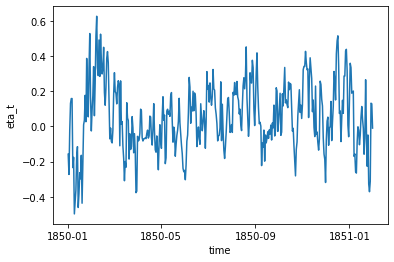

In [13]:
obc_path = "/data/meteo/BalticSea/RecentClimate/coastDat-2_COSMO-CLM/OBC_TROP_9nm/1948/obc_trop_west.dta.nc"

create_obc.interpolate_onto_given_obc(obcpath=obc_path,
                                      lonname="longitude",
                                      latname="latitude").mean(["lon", "lat"]).eta_t.plot()